In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification

In [2]:
import pandas as pd
df = pd.read_csv("retouren.csv")
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)
df = df.drop(df[df.item_price == 999].index)
df = df.drop(df[df.delivery_date < df.order_date].index)
df = df.drop(df[df.item_color == "?"].index)
df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"
df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))
df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days
df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1
df.drop(df[df.delivery_date.isna()].index, inplace=True)

In [3]:
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

In [4]:
df.sort_values('order_date', inplace=True)

# Generate order ID and order size
order_id_generator = df.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

In [5]:
# nth_order_of_user
df_nth_order_of_user = df.groupby(['user_id', 'order_id'], as_index=False).size().drop('size', axis=1)
df_nth_order_of_user['nth_order_of_user'] = df_nth_order_of_user.groupby(['user_id']).cumcount()+1
df = pd.merge(df,df_nth_order_of_user,on=['user_id', 'order_id'], how='left')

# item_id_>1_in_order
item_counts_in_order = df.groupby(['order_id', 'item_id'], as_index=False).size()
item_counts_in_order['item_id_>1_in_order'] = item_counts_in_order['size'] > 1
df = pd.merge(df,item_counts_in_order[['order_id', 'item_id', 'item_id_>1_in_order']],on=['order_id', 'item_id'], how='left')

In [6]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,user_reg_date,return,age,acc_age,maxprice,markdown,order_size,order_id,nth_order_of_user,item_id_>1_in_order
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,...,2016-06-23,0,"(40, 50]",-1,49.90,0,1,0,1,False
1,641,2016-06-22,2016-06-28,100,39,red,43,69.90,30931,Mr,...,2015-02-17,1,"(40, 50]",491,69.90,0,12,1,1,True
2,620,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1,True
3,621,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1,True
4,548,2016-06-22,2016-06-26,173,m,brown,20,19.90,18912,Mrs,...,2015-02-17,1,"(50, 60]",491,49.90,1,8,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66105,74470,2016-08-20,2016-08-21,1749,41,green,43,99.90,4466,Mrs,...,2015-02-17,0,"(50, 60]",550,99.90,0,6,19330,3,False
66106,73772,2016-08-20,2016-08-23,1485,l,grey,42,149.90,30564,Mrs,...,2016-06-22,1,"(50, 60]",59,149.90,0,18,19278,2,True
66107,74672,2016-08-20,2016-08-23,1470,l,green,3,39.90,43724,Mrs,...,2015-02-17,1,"(40, 50]",550,39.90,0,10,19305,1,False
66108,74877,2016-08-20,2016-08-21,608,38,black,15,32.95,36953,Mr,...,2016-07-16,0,"(50, 60]",35,32.95,0,2,19376,2,False


In [6]:
df_order = df.groupby(["order_id", "item_id"]).agg(color= ("item_color", "unique"), size= ("item_size", "unique"), color_count= ("item_color", "count"), size_count= ("item_size", "count"), returned= ("return", "mean")).reset_index()
df_order1 = df_order[(df_order.color_count >1) | (df_order.size_count >1)]
#df_order1.drop(df_order1.loc[df_order1.returned == 0].index, inplace= True)

In [7]:
df_order1.drop(["color","size","color_count","size_count"], axis=1,inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_17900\2747420899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order1.drop(["color","size","color_count","size_count"], axis=1,inplace=True)


In [8]:
df = pd.merge(df,df_order1,on=["order_id","item_id"],how="left")

In [8]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,user_state,user_reg_date,return,age,acc_age,maxprice,markdown,order_size,order_id,returned
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,...,Saxony,2016-06-23,0,"(40, 50]",-1,49.90,0,1,0,NaN
1,641,2016-06-22,2016-06-28,100,39,red,43,69.90,30931,Mr,...,North Rhine-Westphalia,2015-02-17,1,"(40, 50]",491,69.90,0,12,1,0.75
2,620,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,North Rhine-Westphalia,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1.00
3,621,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,North Rhine-Westphalia,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1.00
4,548,2016-06-22,2016-06-26,173,m,brown,20,19.90,18912,Mrs,...,Bavaria,2015-02-17,1,"(50, 60]",491,49.90,1,8,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66105,74470,2016-08-20,2016-08-21,1749,41,green,43,99.90,4466,Mrs,...,Bavaria,2015-02-17,0,"(50, 60]",550,99.90,0,6,19330,NaN
66106,73772,2016-08-20,2016-08-23,1485,l,grey,42,149.90,30564,Mrs,...,Baden-Wuerttemberg,2016-06-22,1,"(50, 60]",59,149.90,0,18,19278,1.00
66107,74672,2016-08-20,2016-08-23,1470,l,green,3,39.90,43724,Mrs,...,Rhineland-Palatinate,2015-02-17,1,"(40, 50]",550,39.90,0,10,19305,NaN
66108,74877,2016-08-20,2016-08-21,608,38,black,15,32.95,36953,Mr,...,North Rhine-Westphalia,2016-07-16,0,"(50, 60]",35,32.95,0,2,19376,NaN


In [9]:
df_return_ratio = df.groupby("item_id").agg(returned = ("return", "sum"), item_order= ("return", "count")).reset_index()
df_return_ratio["not_returned"] = df_return_ratio.item_order - df_return_ratio.returned
df_return_ratio["return_ratio"] = df_return_ratio.returned / df_return_ratio.item_order

In [10]:
df_return_ratio.drop(["returned","item_order","not_returned"],axis=1,inplace=True)

In [11]:
df = pd.merge(df,df_return_ratio,on="item_id",how="left")

In [13]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,user_reg_date,return,age,acc_age,maxprice,markdown,order_size,order_id,returned,return_ratio
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,...,2016-06-23,0,"(40, 50]",-1,49.90,0,1,0,NaN,0.166667
1,641,2016-06-22,2016-06-28,100,39,red,43,69.90,30931,Mr,...,2015-02-17,1,"(40, 50]",491,69.90,0,12,1,0.75,0.639493
2,620,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1.00,0.410959
3,621,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,2015-02-17,1,"(50, 60]",491,12.90,1,10,2,1.00,0.410959
4,548,2016-06-22,2016-06-26,173,m,brown,20,19.90,18912,Mrs,...,2015-02-17,1,"(50, 60]",491,49.90,1,8,3,NaN,0.689286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66105,74470,2016-08-20,2016-08-21,1749,41,green,43,99.90,4466,Mrs,...,2015-02-17,0,"(50, 60]",550,99.90,0,6,19330,NaN,0.500000
66106,73772,2016-08-20,2016-08-23,1485,l,grey,42,149.90,30564,Mrs,...,2016-06-22,1,"(50, 60]",59,149.90,0,18,19278,1.00,0.517483
66107,74672,2016-08-20,2016-08-23,1470,l,green,3,39.90,43724,Mrs,...,2015-02-17,1,"(40, 50]",550,39.90,0,10,19305,NaN,0.458204
66108,74877,2016-08-20,2016-08-21,608,38,black,15,32.95,36953,Mr,...,2016-07-16,0,"(50, 60]",35,32.95,0,2,19376,NaN,0.272727


In [64]:
#df = pd.get_dummies(df[["item_id", 	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"markdown", "age"]],dummy_na=True)

In [13]:
df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,age,acc_age,maxprice,markdown,order_size,order_id,nth_order_of_user,item_id_>1_in_order,returned,return_ratio
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,...,"(40, 50]",-1,49.90,0,1,0,1,False,NaN,0.166667
1,641,2016-06-22,2016-06-28,100,39,red,43,69.90,30931,Mr,...,"(40, 50]",491,69.90,0,12,1,1,True,0.75,0.639493
2,620,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,"(50, 60]",491,12.90,1,10,2,1,True,1.00,0.410959
3,621,2016-06-22,2016-07-04,523,xl,magenta,3,7.90,30929,Mrs,...,"(50, 60]",491,12.90,1,10,2,1,True,1.00,0.410959
4,548,2016-06-22,2016-06-26,173,m,brown,20,19.90,18912,Mrs,...,"(50, 60]",491,49.90,1,8,3,1,False,NaN,0.689286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66105,74470,2016-08-20,2016-08-21,1749,41,green,43,99.90,4466,Mrs,...,"(50, 60]",550,99.90,0,6,19330,3,False,NaN,0.500000
66106,73772,2016-08-20,2016-08-23,1485,l,grey,42,149.90,30564,Mrs,...,"(50, 60]",59,149.90,0,18,19278,2,True,1.00,0.517483
66107,74672,2016-08-20,2016-08-23,1470,l,green,3,39.90,43724,Mrs,...,"(40, 50]",550,39.90,0,10,19305,1,False,NaN,0.458204
66108,74877,2016-08-20,2016-08-21,608,38,black,15,32.95,36953,Mr,...,"(50, 60]",35,32.95,0,2,19376,2,False,NaN,0.272727


In [12]:
#Trainingsdaten
X = pd.get_dummies(df[["item_id", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"markdown", "age","acc_age", "item_size","return_ratio","order_size","order_id","nth_order_of_user","item_id_>1_in_order" ]])
y = df["return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [27]:
X_train

,item_id,brand_id,item_price,user_id,markdown,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,item_color_antique pink,...,user_state_Hesse,user_state_Lower Saxony,user_state_Mecklenburg-Western Pomerania,user_state_North Rhine-Westphalia,user_state_Rhineland-Palatinate,user_state_Saarland,user_state_Saxony,user_state_Saxony-Anhalt,user_state_Schleswig-Holstein,user_state_Thuringia
5061,114,43,79.9,41363,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52884,1687,3,39.9,40378,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
59665,1552,49,199.9,22100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45698,1359,51,44.9,34058,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
63563,1958,11,69.9,40844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48711,1550,117,129.9,6301,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24679,328,37,19.9,22407,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52790,1636,113,69.9,23933,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49357,1569,11,69.9,20074,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
#Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
#You can grid search over parameters of all estimators in the pipeline at once.
#You only have to call fit and predict once on your data to fit a whole sequence of estimators.

pipe = make_pipeline(StandardScaler(),
                     #SVC(cache_size=800,kernel="poly")
                     LinearSVC( tol=1e-5,dual=False,max_iter=10000)
                     )

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.score


In [28]:
#pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=5))])

In [29]:
#y_predict = pipe.predict(X_test)

In [17]:
#pipe.score(X_train,y_train,0.2)

In [19]:
#cv = ShuffleSplit(n_splits=10, test_size=0.2)

In [16]:
#scores = cross_val_score(pipe, X_train, y_train,n_jobs=4,scoring="accuracy")

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

https://scikit-learn.org/stable/modules/compose.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

In [19]:
X_train

,item_id,brand_id,item_price,user_id,markdown,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,item_color_antique pink,...,user_state_Hesse,user_state_Lower Saxony,user_state_Mecklenburg-Western Pomerania,user_state_North Rhine-Westphalia,user_state_Rhineland-Palatinate,user_state_Saarland,user_state_Saxony,user_state_Saxony-Anhalt,user_state_Schleswig-Holstein,user_state_Thuringia
5061,114,43,79.9,41363,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52884,1687,3,39.9,40378,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
59665,1552,49,199.9,22100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45698,1359,51,44.9,34058,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
63563,1958,11,69.9,40844,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48711,1550,117,129.9,6301,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24679,328,37,19.9,22407,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52790,1636,113,69.9,23933,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49357,1569,11,69.9,20074,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [17]:
param_grid = {
    "linearsvc__C": np.linspace(0.001, 3, 20),
    #"svc__C": np.logspace(0.1, 20, 5)
    #"linearsvc__class_weight": [None,{1: 0.8,0:1},{1: 0.6,0:1},{1: 0.4,0:1}]
}
grid = GridSearchCV(pipe,param_grid,scoring="accuracy",n_jobs=2,return_train_score=True)

In [18]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(dual=False, max_iter=10000,
                                                  tol=1e-05))]),
             n_jobs=2,
             param_grid={'linearsvc__C': array([1.00000000e-03, 1.58842105e-01, 3.16684211e-01, 4.74526316e-01,
       6.32368421e-01, 7.90210526e-01, 9.48052632e-01, 1.10589474e+00,
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00])},
             return_train_score=True, scoring='accuracy')

In [57]:
np.linspace(0.001, 3, 20)

array([1.00000000e-03, 1.58842105e-01, 3.16684211e-01, 4.74526316e-01,
       6.32368421e-01, 7.90210526e-01, 9.48052632e-01, 1.10589474e+00,
       1.26373684e+00, 1.42157895e+00, 1.57942105e+00, 1.73726316e+00,
       1.89510526e+00, 2.05294737e+00, 2.21078947e+00, 2.36863158e+00,
       2.52647368e+00, 2.68431579e+00, 2.84215789e+00, 3.00000000e+00])

In [19]:
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)

Best parameter (CV score=0.643):
{'linearsvc__C': 0.001}


In [14]:
#bestes modell mit C = 0.001
pipe = make_pipeline(StandardScaler(),
                     #SVC(cache_size=800,kernel="poly")
                     LinearSVC( tol=1e-5,dual=False,max_iter=10000,C=0.001)
                     )
pipe.fit(X_train,y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.001, dual=False, max_iter=10000, tol=1e-05))])

In [23]:
clf = CalibratedClassifierCV(pipe,cv="prefit")
clf.fit(X_train,y_train)


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('standardscaler',
                                                       StandardScaler()),
                                                      ('linearsvc',
                                                       LinearSVC(C=0.001,
                                                                 dual=False,
                                                                 max_iter=10000,
                                                                 tol=1e-05))]),
                       cv='prefit')

In [14]:
y_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train,y_pred)
print('accuracy score : ',acc_score)

accuracy score :  0.5790538496445319


In [15]:
y_predict = clf.predict(X_test)
acc_score = accuracy_score(y_predict,y_test)
print('accuracy score : ',acc_score)

accuracy score :  0.575404628649221


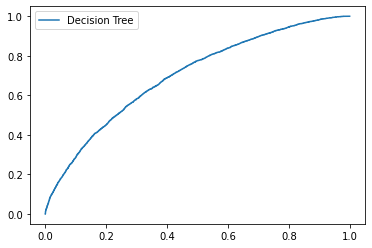

In [24]:

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
#fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, m_lr.predict_proba(X_test)[:,1])

plt.step(x=fpr_dt, y=tpr_dt, label="Decision Tree")
#plt.step(x=fpr_lr, y=tpr_lr, label="Logistic Regression")
plt.legend()

In [15]:
y_pred = pipe.predict(X_train)
acc_score = accuracy_score(y_train,y_pred)
print('accuracy score : ',acc_score)

accuracy score :  0.647368022991983


In [16]:
y_predict = pipe.predict(X_test)
acc_score = accuracy_score(y_predict,y_test)
print('accuracy score : ',acc_score)

accuracy score :  0.6436242625926486


In [27]:
recall = recall_score(y_train, y_pred)
print(recall)

0.6680115058463147


In [28]:
recall = recall_score(y_test, y_predict)
print(recall)

0.6675696012039127


In [29]:
prec = precision_score(y_train, y_pred)
print(prec)

0.6415297409772548


In [30]:
prec = precision_score(y_test, y_predict)
print(prec)

0.631099729691279


für aufgabe 6 comparison y_test und y_predict nur die 1 wenn tatsächlich 1 dann +3,5 wenn nicht dann minus 0,1*item_price

In [24]:
y_predict

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [25]:
y_test

58185    1
52655    1
24833    1
31786    1
64928    0
        ..
57261    1
25443    0
42038    0
32590    0
23735    0
Name: return, Length: 13222, dtype: int64

In [65]:
def Aufgabe6(y_test,y_pred,X_test,Modelname: str):
    """
    Die funktion Aufgabe6 gibt einen String mit zurück, der das bestimmete Modell nennt und ihren Wert angibt,
    den Sie auf den Testdaten erzielen würde

    y_test: label array der Testdaten
    y_pred: die label die das entsprechende Modell auf den Testdaten(testfeatures) hervorgesagt hat
    X_test: Features der Testdaten
    Modelname: Name des Model als string
    
    

    """
    df_aufgabe6 = X_test.copy()
    Modelname = Modelname
    df_aufgabe6["return_predict"] = y_pred
    df_aufgabe6["return_test"] = y_test
    df_aufgabe6["Abgleich"] = df_aufgabe6.return_predict == df_aufgabe6.return_test
    df_aufgabe6 = df_aufgabe6.drop(df_aufgabe6.loc[(df_aufgabe6.return_predict == 0)&(df_aufgabe6.Abgleich == True)].index)
    df_aufgabe6["sume"] = 0
    df_aufgabe6.loc[df_aufgabe6.Abgleich == True,"sume"]  = 3.5 # Wir sagen dass wir bei richtige Vorhersage ein Plus von 3.5€ erreichen
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 1),"sume"] = df_aufgabe6.item_price*(-0.1)*0.5 # bei fälschlicher Vorhersage einer Retoure gehen wir von einem Verlust von 50% des 10%tigen itemprice
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 0),"sume"] = -7 # beim nicht erkennen einer Retoure gehen wir von einem Verlust von 7€ aus
    return print(f"Das Modell {Modelname} würde auf den jetzigen Testdaten einen Bonus von {df_aufgabe6.sume.sum()} erschaffen")
    


In [66]:
Aufgabe6(y_test,y_predict,X_test,"SVM")

Das Modell SVM würde auf den jetzigen Testdaten einen Bonus von 6510.467499999998 erschaffen


In [55]:
df_aufgabe6 = X_test.copy()
df_aufgabe6["return_predict"] = y_predict
df_aufgabe6["return_test"] = y_test
df_aufgabe6["Abgleich"] = df_aufgabe6.return_predict == df_aufgabe6.return_test

In [57]:
df_aufgabe6 = df_aufgabe6.drop(df_aufgabe6.loc[(df_aufgabe6.return_predict == 0)&(df_aufgabe6.Abgleich == True)].index)

In [62]:
df_aufgabe6

array([False])

In [26]:
X_test["return1"] = y_predict

In [29]:
X_test

,item_id,brand_id,item_price,user_id,markdown,acc_age,return_ratio,order_size,order_id,nth_order_of_user,...,item_size_90,item_size_l,item_size_m,item_size_s,item_size_unsized,item_size_xl,item_size_xs,item_size_xxl,item_size_xxxl,return1
58185,2093,42,29.9,42193,0,175,0.333333,8,17074,1,...,0,0,0,0,1,0,0,0,0,0
52655,1147,42,49.9,4003,0,420,0.666667,7,15644,5,...,0,0,0,0,0,1,0,0,0,1
24833,579,3,19.9,33206,0,7,0.462500,5,7445,2,...,0,0,0,0,0,0,0,1,0,0
31786,1507,102,24.9,22257,0,518,0.389535,5,9840,4,...,0,0,0,0,1,0,0,0,0,0
64928,1710,50,130.0,43677,0,-1,0.352941,1,19089,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57261,322,4,59.9,12051,0,-1,0.576923,2,17121,1,...,0,0,0,0,0,0,0,0,0,1
25443,33,5,59.9,27390,1,507,0.220339,36,7664,1,...,0,1,0,0,0,0,0,0,0,0
42038,219,38,79.9,39257,0,333,0.314607,2,13211,1,...,0,0,0,0,0,0,0,0,0,0
32590,209,37,34.9,37337,0,-1,0.452381,6,9913,1,...,0,0,1,0,0,0,0,0,0,0


In [31]:
X_test.drop("return1",axis=1,inplace=True)

In [32]:
X_test["return_true"] = y_test

In [33]:
X_test["idk"] = X_test.return1 == X_test.return_true

In [34]:
df_aufgabe6 = X_test[X_test.return1 == 1]

In [35]:
df_aufgabe6["sum"] = 0

C:\Users\paulh\AppData\Local\Temp\ipykernel_12672\766378953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6["sum"] = 0


In [36]:
df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5

C:\Users\paulh\AppData\Local\Temp\ipykernel_12672\287104434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aufgabe6.loc[df_aufgabe6.idk == True,"sum"]  = 3.5


In [37]:
df_aufgabe6.loc[df_aufgabe6.idk == False,"sum"] = df_aufgabe6.item_price*(-0.1)*0.5

In [109]:
df_aufgabe6

,item_id,brand_id,item_price,user_id,markdown,acc_age,item_color_almond,item_color_amethyst,item_color_ancient,item_color_anthracite,...,item_size_unsized,item_size_xl,item_size_xs,item_size_xxl,item_size_xxxl,return,return_true,return1,idk,sum
59855,1518,37,39.9,9643,0,429,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-1.995
28923,676,19,49.9,35437,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-2.495
72805,1497,1,129.9,13729,0,279,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-6.495
73672,1558,1,169.9,43231,0,547,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
45119,58,31,89.9,36053,0,507,0,0,0,0,...,0,0,0,1,0,1,1,1,True,3.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54000,1666,36,99.9,40193,0,340,0,0,0,0,...,0,0,0,0,0,1,0,1,False,-4.995
55407,1863,12,170.0,12045,0,521,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
64716,1903,113,69.9,20258,0,541,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500
38099,185,11,44.9,7991,1,547,0,0,0,0,...,0,0,0,0,0,1,1,1,True,3.500


In [38]:
df_aufgabe6["sum"].sum()

6045.219999999998